# Dependencies and imports
This notebook use tensorflow-gpu 1.15.5 this will trigger a pip error at the end of the cell execution, please ignore the error because those dependencies won't affect us.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip uninstall -y -q keras-nightly
!pip install -q keras==2.0.8 tensorflow-gpu==1.15.5 h5py==2.10.0 mrcnn-colab==2.1

     |████████████████████████████████| 276 kB 13.1 MB/s 
     |████████████████████████████████| 411.0 MB 27 kB/s 
     |████████████████████████████████| 2.9 MB 29.5 MB/s 
     |████████████████████████████████| 56 kB 5.1 MB/s 
     |████████████████████████████████| 50 kB 5.9 MB/s 
     |████████████████████████████████| 3.8 MB 37.6 MB/s 
     |████████████████████████████████| 503 kB 49.6 MB/s 
     |████████████████████████████████| 20.1 MB 1.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.5.0 requires keras-nightly~=2.5.0.dev, which is not installed.
tensorflow 2.5.0 requires gast==0.4.0, but you have gast 0.2.2 which is incompatible.
tensorflow 2.5.0 requires h5py~=3.1.0, but you have h5py 2.10.0 which is incompatible.
tensorflow 2.5.0 requires numpy~=1.19.2, but you have numpy 1.18.5 which is incompatible.
tensorflow 2.5.0 requires 

In [2]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import urllib
from mrcnn.config import Config
from mrcnn import model as modellib, utils

Using TensorFlow backend.


# Download Files and create Root Folder

This setup should work out of the box, in case you want to move to a custom path just change the ROOT_DIR.

In [6]:
ROOT_DIR = os.path.abspath("test")
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

DATA_SET_PATH = os.path.join(ROOT_DIR, "vehicle-detection-rcnn-main/dataset")
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

COCO_RCNN_URL = "https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5"
MRCNN_REPO_URL = "https://github.com/martinezger/vehicle-detection-rcnn/archive/refs/heads/main.zip"

if not os.path.exists(ROOT_DIR):
  print("create project root folder")
  os.mkdir(ROOT_DIR)

!wget "https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5" -P {ROOT_DIR}
!wget "https://github.com/martinezger/vehicle-detection-rcnn/archive/refs/heads/main.zip" -P {ROOT_DIR}
!unzip -qq {os.path.join(ROOT_DIR, "main.zip")} "vehicle-detection-rcnn-main/dataset/*" -d {ROOT_DIR}
!rm {os.path.join(ROOT_DIR, "main.zip")}

--2021-07-27 12:29:29--  https://github.com/martinezger/vehicle-detection-rcnn/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/martinezger/vehicle-detection-rcnn/zip/refs/heads/main [following]
--2021-07-27 12:29:29--  https://codeload.github.com/martinezger/vehicle-detection-rcnn/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.121.9
Connecting to codeload.github.com (codeload.github.com)|140.82.121.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/content/test/main.zip’

main.zip                [ <=>                ]   1.92M  --.-KB/s    in 0.1s    

2021-07-27 12:29:29 (13.8 MB/s) - ‘/content/test/main.zip’ saved [2016101]



# Model Setup


In [5]:

############################################################
#  Configurations
############################################################

class CustomCarConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "customCar"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # Background + cars + bus + truck

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 14

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9


############################################################
#  Dataset
############################################################

class CustomCarDataset(utils.Dataset):

    def load_car(self, dataset_dir, subset):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("customCar", 1, "car")
        self.add_class("customCar", 2, "truck")
        self.add_class("customCar", 3, "bus")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        for a in annotations:
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']]

            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]
            name = [r["region_attributes"]["name"] for r in a["regions"]]
            name_dict = {"car": 1, "truck": 2, "bus": 3}
            name_id = [name_dict[a] for a in name]

            self.add_image(
                "customCar",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                class_id=name_id,
                width=width,
                height=height,
                polygons=polygons)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a balloon dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "customCar":
            return super(self.__class__, self).load_mask(image_id)

        name_id = image_info['class_id']

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)

        class_ids = np.array(name_id, dtype=np.int32)

        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), class_ids

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "customCar":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


def train(model, config):
    """Train the model."""
    # Training dataset.
    dataset_train = CustomCarDataset()
    dataset_train.load_car(DATA_SET_PATH, "train")
    dataset_train.prepare()

    # Validation dataset
    dataset_val = CustomCarDataset()
    dataset_val.load_car(DATA_SET_PATH, "val")
    dataset_val.prepare()

    # *** This training schedule is an example. Update to your needs ***
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=30,
                layers='heads')


def color_splash(image, mask):
    """Apply color splash effect.
    image: RGB image [height, width, 3]
    mask: instance segmentation mask [height, width, instance count]
    Returns result image.
    """
    # Make a grayscale copy of the image. The grayscale copy still
    # has 3 RGB channels, though.
    gray = skimage.color.gray2rgb(skimage.color.rgb2gray(image)) * 255
    # Copy color pixels from the original color image where mask is set
    if mask.shape[-1] > 0:
        # We're treating all instances as one, so collapse the mask into one layer
        mask = (np.sum(mask, -1, keepdims=True) >= 1)
        splash = np.where(mask, image, gray).astype(np.uint8)
    else:
        splash = gray.astype(np.uint8)
    return splash


def run(command, dataset=DATA_SET_PATH, weights="coco", logs=DEFAULT_LOGS_DIR):

    if command not in ["train", "inference"]:
        raise ValueError("command only accept train or inference as valid values")

    # Validate arguments
    if command == "train":
        assert dataset, "Argument --dataset is required for training"

    print("Weights: ", weights)
    print("Dataset: ", dataset)
    print("Logs: ", logs)

    # Configurations
    if command == "train":
        config = CustomCarConfig()
    else:
        class InferenceConfig(CustomCarConfig):
            # Set batch size to 1 since we'll be running inference on
            # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
            GPU_COUNT = 1
            IMAGES_PER_GPU = 1

        config = InferenceConfig()
    config.display()

    # Create model
    if command == "train":
        model = modellib.MaskRCNN(mode="training", config=config,
                                  model_dir=logs)
    else:
        model = modellib.MaskRCNN(mode="inference", config=config,
                                  model_dir=logs)

    # Select weights file to load
    if weights.lower() == "coco":
        weights_path = COCO_WEIGHTS_PATH
        # Download weights file
        if not os.path.exists(weights_path):
            utils.download_trained_weights(weights_path)
    elif weights.lower() == "last":
        # Find last trained weights
        weights_path = model.find_last()
    elif weights.lower() == "imagenet":
        # Start from ImageNet trained weights
        weights_path = model.get_imagenet_weights()
    else:
        weights_path = weights

    # Load weights
    print("Loading weights ", weights_path)
    if weights.lower() == "coco":
        # Exclude the last layers because they require a matching
        # number of classes
        model.load_weights(weights_path, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])
    else:
        model.load_weights(weights_path, by_name=True)

    # Train or evaluate
    if command == "train":
        train(model, config)

    else:
        print("'{}' is not recognized. "
              "Use 'train' or 'splash'".format(command))


# Run Training
After hit start the training will start. Base on some testing I made could take between 30 to 60 minutes to finish a traning.

In [6]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
run("train")

Weights:  coco
Dataset:  /content/test/rcnn-mvc-main/dataset
Logs:  /content/test/logs

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_lo

/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor





/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/30
13/14 [==========================>...] - ETA: 4s - loss: 2.8109 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.3306 - mrcnn_class_loss: 0.4170 - mrcnn_bbox_loss: 0.8096 - mrcnn_mask_loss: 1.2501

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2142: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'



14/14 [==============================] - 144s - loss: 2.7325 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.3258 - mrcnn_class_loss: 0.4002 - mrcnn_bbox_loss: 0.7990 - mrcnn_mask_loss: 1.2032 - val_loss: 1.9837 - val_rpn_class_loss: 0.0038 - val_rpn_bbox_loss: 0.1738 - val_mrcnn_class_loss: 0.1121 - val_mrcnn_bbox_loss: 0.8312 - val_mrcnn_mask_loss: 0.8628
Epoch 2/30
14/14 [==============================] - 47s - loss: 1.3998 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1963 - mrcnn_class_loss: 0.0802 - mrcnn_bbox_loss: 0.4813 - mrcnn_mask_loss: 0.6364 - val_loss: 1.3804 - val_rpn_class_loss: 0.0032 - val_rpn_bbox_loss: 0.1610 - val_mrcnn_class_loss: 0.0695 - val_mrcnn_bbox_loss: 0.5933 - val_mrcnn_mask_loss: 0.5534
Epoch 3/30
14/14 [==============================] - 46s - loss: 1.0840 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.1467 - mrcnn_class_loss: 0.0645 - mrcnn_bbox_loss: 0.3793 - mrcnn_mask_loss: 0.4884 - val_loss: 1.2185 - val_rpn_class_loss: 0.0045 - val_rpn_bbox_loss: 0.1345 - 

# Run Inference
After hit start the training will start. Base on some testing I made could take between 10 to 15 minutes to finish a traning.

In [ ]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
run("inference")

# Run prediction

Pay attention in, WEIGHTS path file will vary so change `customcar20210727T1123` with yours. 


In [20]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from mrcnn.visualize import display_instances
from mrcnn.config import Config
from mrcnn.model import MaskRCNN

class_names = ['background', 'car', 'truck', 'bus']


class TestConfig(Config):
    NAME = "test"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 3


WEIGHTS = os.path.join(ROOT_DIR, 'logs', 'customcar20210727T1123','mask_rcnn_customcar_0028.h5') # customcar20210727T1123 WILL VARY check before run.

def run_predict(image, weights=WEIGHTS, verbose=False):
  rcnn = MaskRCNN(mode='inference', model_dir=ROOT_DIR, config=TestConfig())
  rcnn.load_weights(weights, by_name=True)
  img = load_img(image)
  img = img_to_array(img)
  results = rcnn.detect([img], verbose=0)
  r = results[0]
  print((r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])) if verbose else None
  display_instances(img, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

Re-starting from epoch 28


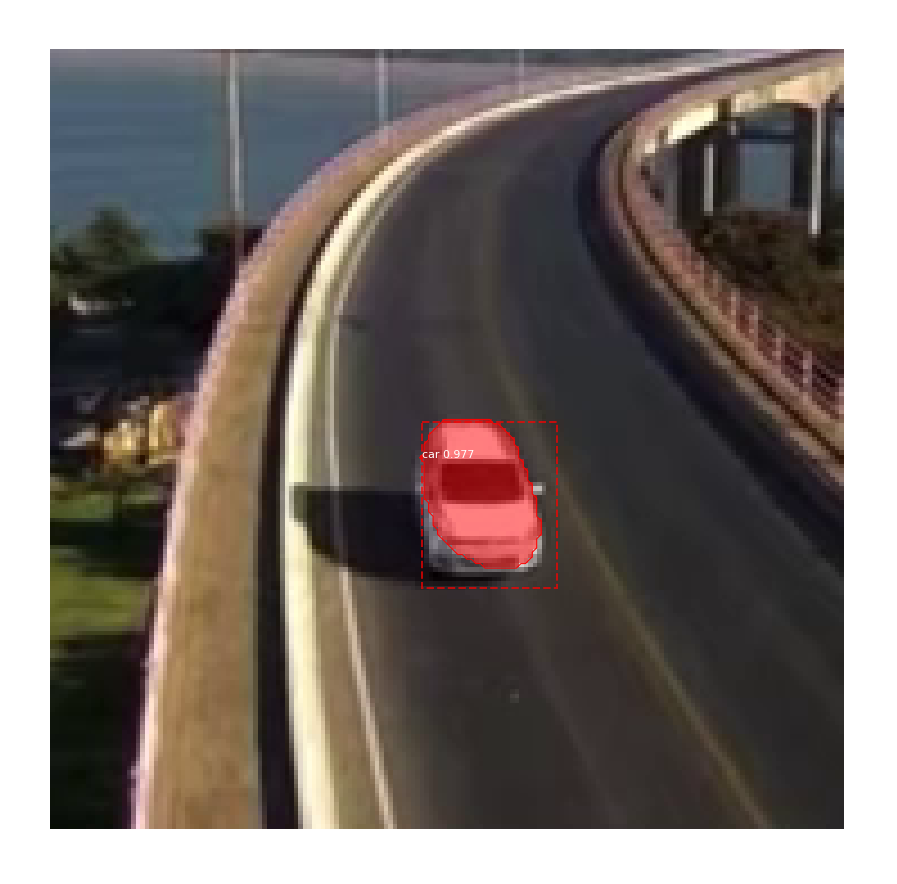

In [21]:
CAR = os.path.join(DATA_SET_PATH, 'samples', 'car.png')
run_predict(CAR)

Re-starting from epoch 28


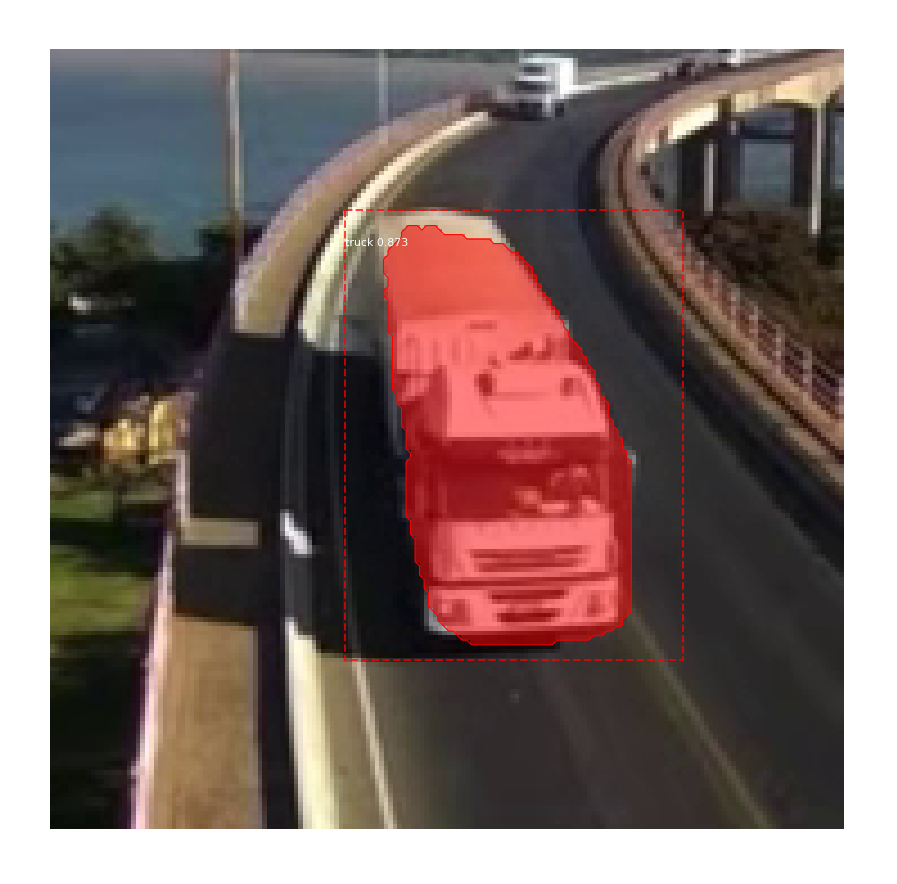

In [22]:
TRUCK = os.path.join(DATA_SET_PATH, 'samples', 'truck.png')
run_predict(TRUCK)

Re-starting from epoch 28


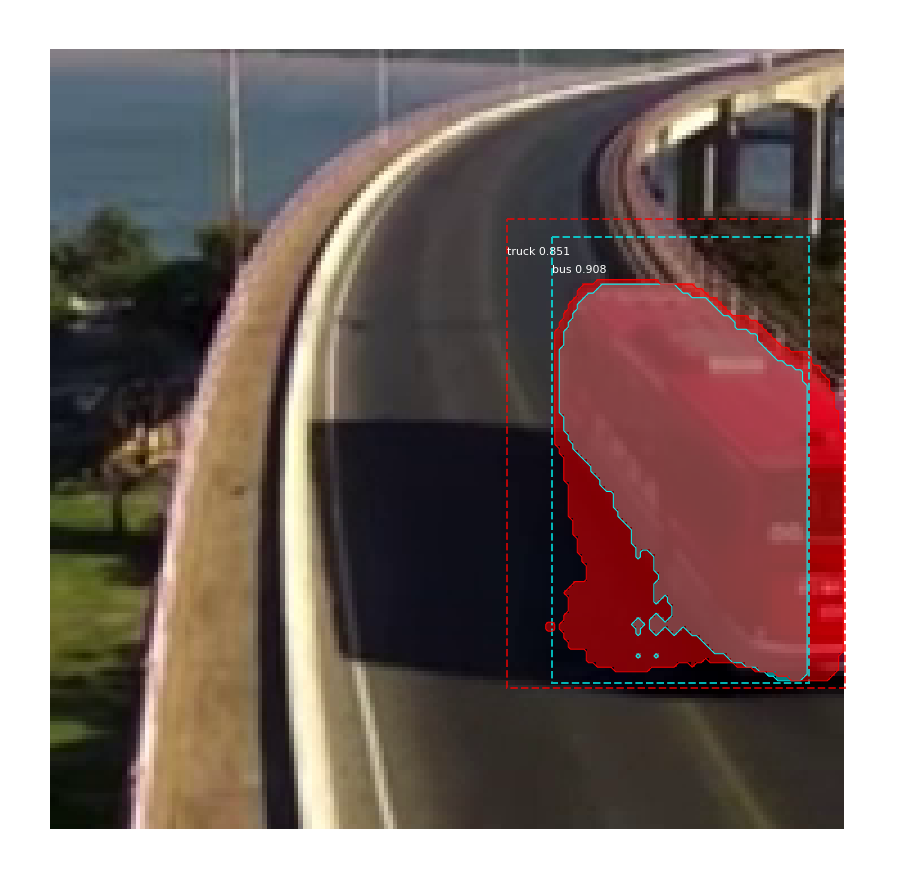

In [23]:
BUS = os.path.join(DATA_SET_PATH, 'samples', 'bus.png')
run_predict(BUS)